In [1]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import cufflinks as cf
from sklearn.metrics import mean_absolute_percentage_error
cf.go_offline()

## Data Collection and Data Manipulation

In [2]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-22', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [3]:
tsla = get_finance_data('tsla')

In [4]:
tsla

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,34334500
...,...,...,...,...,...
2021-10-15,823.739990,843.210022,822.349976,843.030029,18818000
2021-10-18,851.789978,875.260010,851.469971,870.109985,24207200
2021-10-19,877.530029,877.950012,862.510010,864.270020,17381100


In [5]:
tsla_close = tsla[['Close']]

## Data Visualization

In [6]:
tsla_close.iplot(title='Stock Close Prices', fill = True, xTitle='Dates',yTitle='Close Prices', theme='space')

In [7]:
tsla['Volume'].iplot(title='Volume', xTitle='Dates', yTitle='Volume', theme='space')

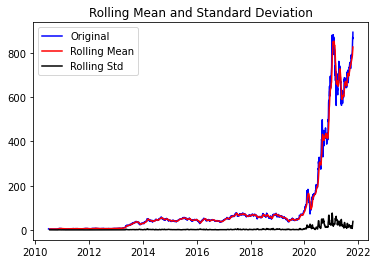

Results of dickey fuller test
Test Statistics                   2.788448
p-value                           1.000000
No. of lags used                 28.000000
Number of observations used    2821.000000
critical value (1%)              -3.432670
critical value (5%)              -2.862565
critical value (10%)             -2.567316
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(tsla_close)

<Figure size 432x288 with 0 Axes>

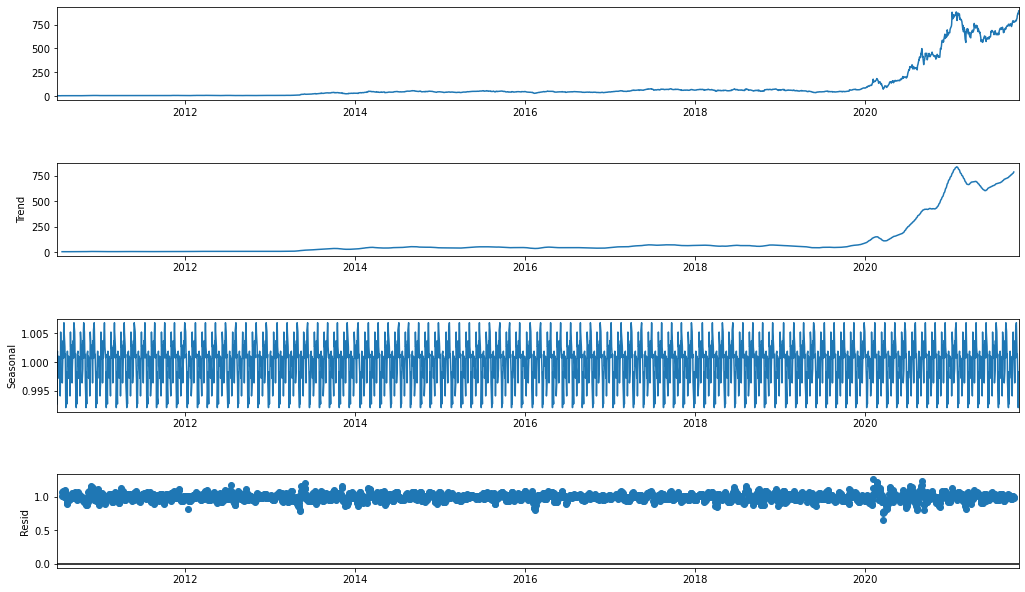

In [9]:
result = seasonal_decompose(tsla_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Time Series Data Manipulation

In [10]:
tsla_close

,Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2021-10-15,843.030029
2021-10-18,870.109985
2021-10-19,864.270020


## ADF Test

Check for stationary series using the Augmented Dickey Fuller Test.
The ADF test indicates whether or not differencing has to be done or not

In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(tsla_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.788448
p-value: 1.000000


## Differencing Term (d)

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

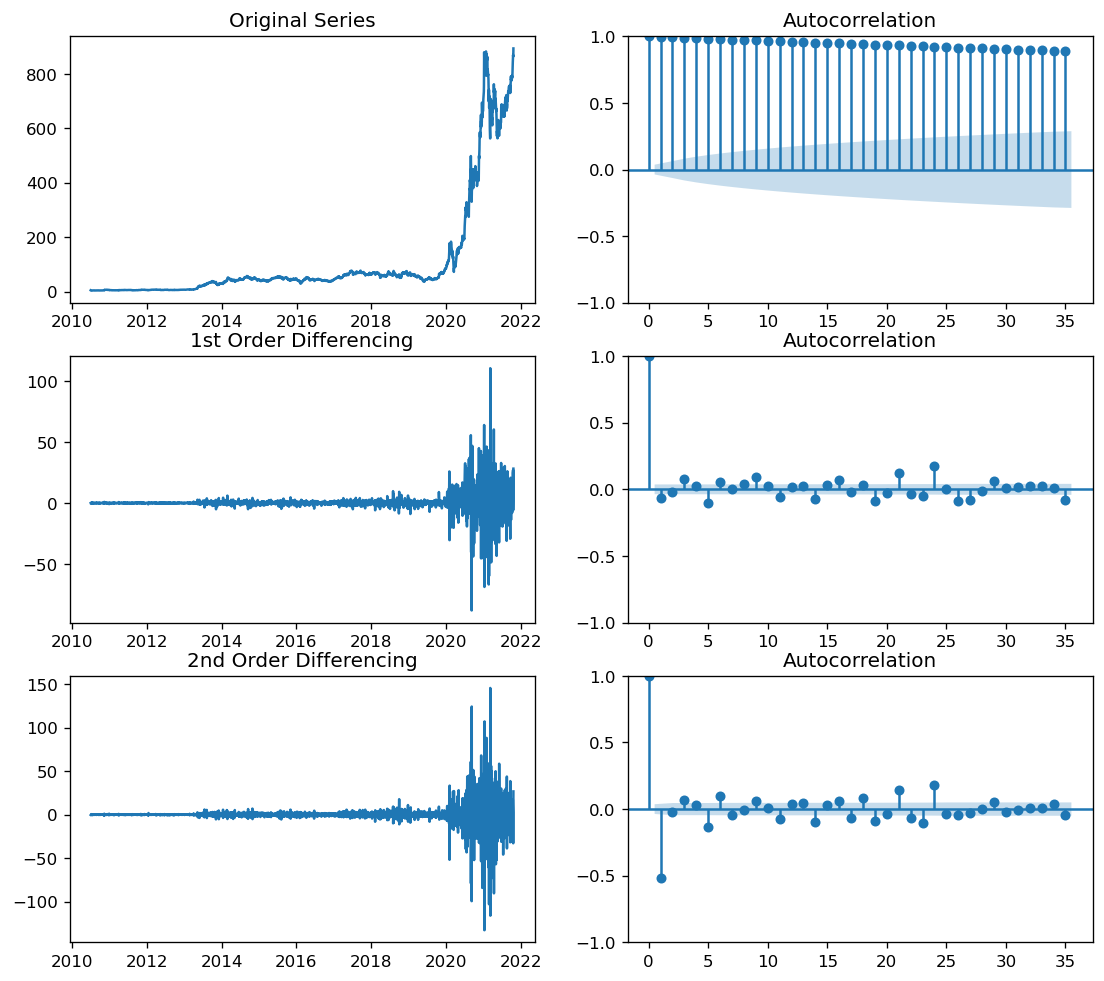

In [12]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(tsla_close); axes[0, 0].set_title('Original Series')
plot_acf(tsla_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(tsla_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(tsla_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(tsla_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(tsla_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced

## AR term (p)

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



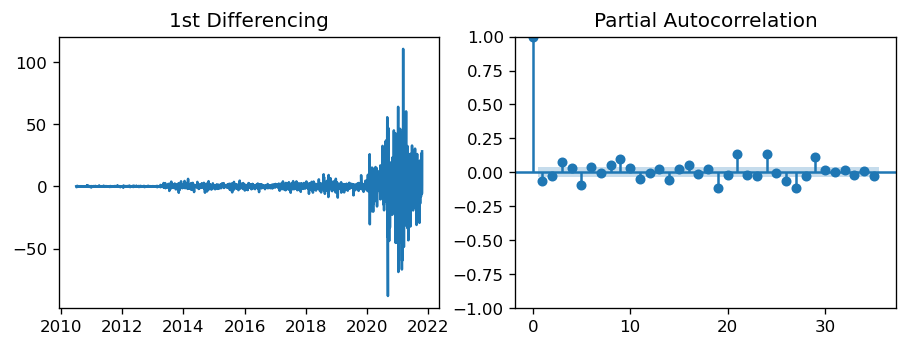

In [13]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(tsla_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(tsla_close.diff().dropna(), ax=axes[1])

plt.show()

ACF lag 1 is quite significant since is well above the significance line, that is why the lag term will be closer to 1

## MA Term (q)

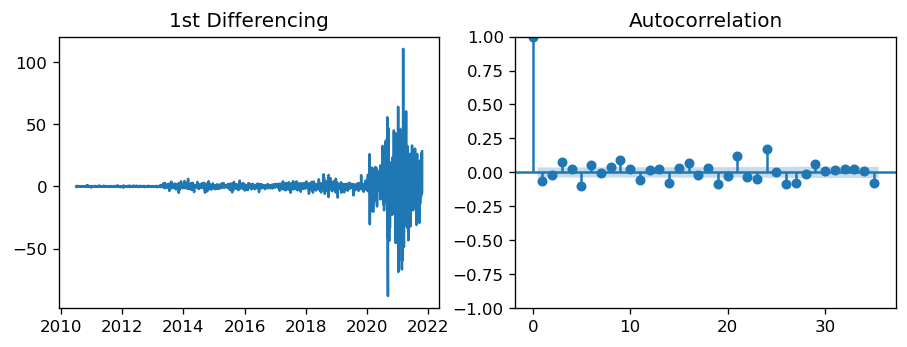

In [14]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(tsla_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(tsla_close.diff().dropna(), ax=axes[1])

plt.show()

The 1st lag is well above the signifigance line so the q term will be set to 1

# ARIMA Model

## Train-Test Split

In [15]:
n = int(len(tsla_close) * 0.80)
train = tsla_close[:n]
test = tsla_close[n:]

In [16]:
train

,Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2019-07-15,50.700001
2019-07-16,50.476002
2019-07-17,50.972000


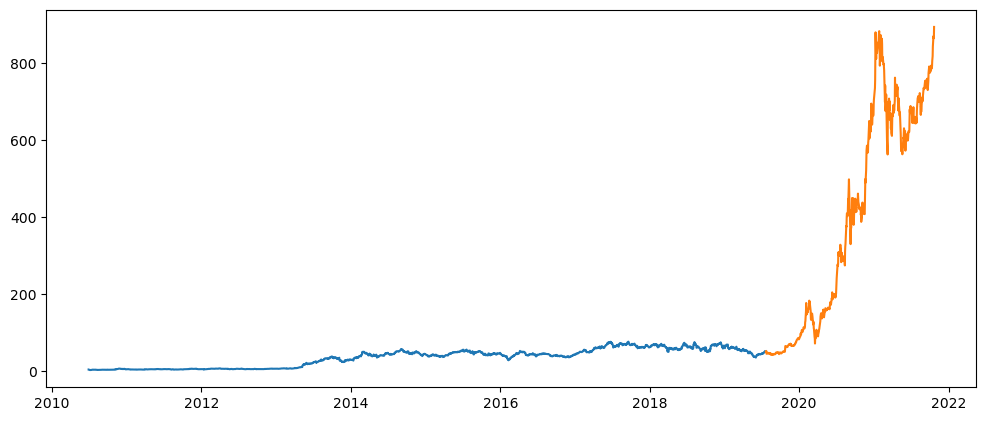

In [17]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [18]:
model = SARIMAX(tsla_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2850
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -9866.234
Date:                Thu, 28 Oct 2021   AIC                          19738.468
Time:                        07:52:07   BIC                          19756.332
Sample:                             0   HQIC                         19744.910
                               - 2850                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0321      0.089      0.362      0.717      -0.141       0.206
ma.L1         -0.0954      0.087     -1.100      0.272      -0.266       0.075
sigma2        59.6296      0.356    167.355      0.0

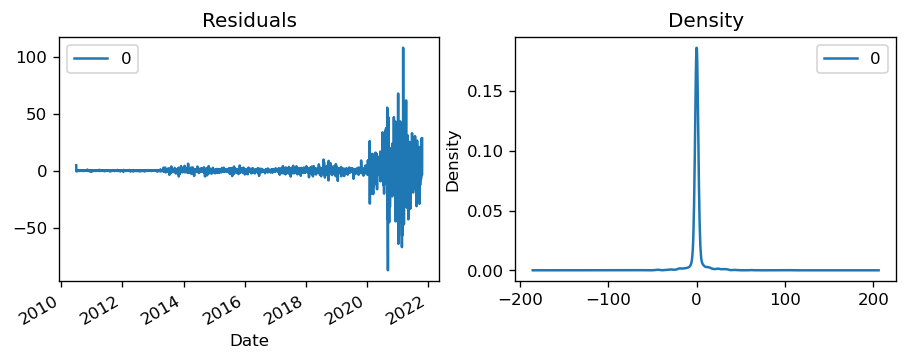

In [19]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [20]:
pred = model_fit.predict(start=pd.to_datetime('2019-04-08'), dynamic=False)
plt.show()

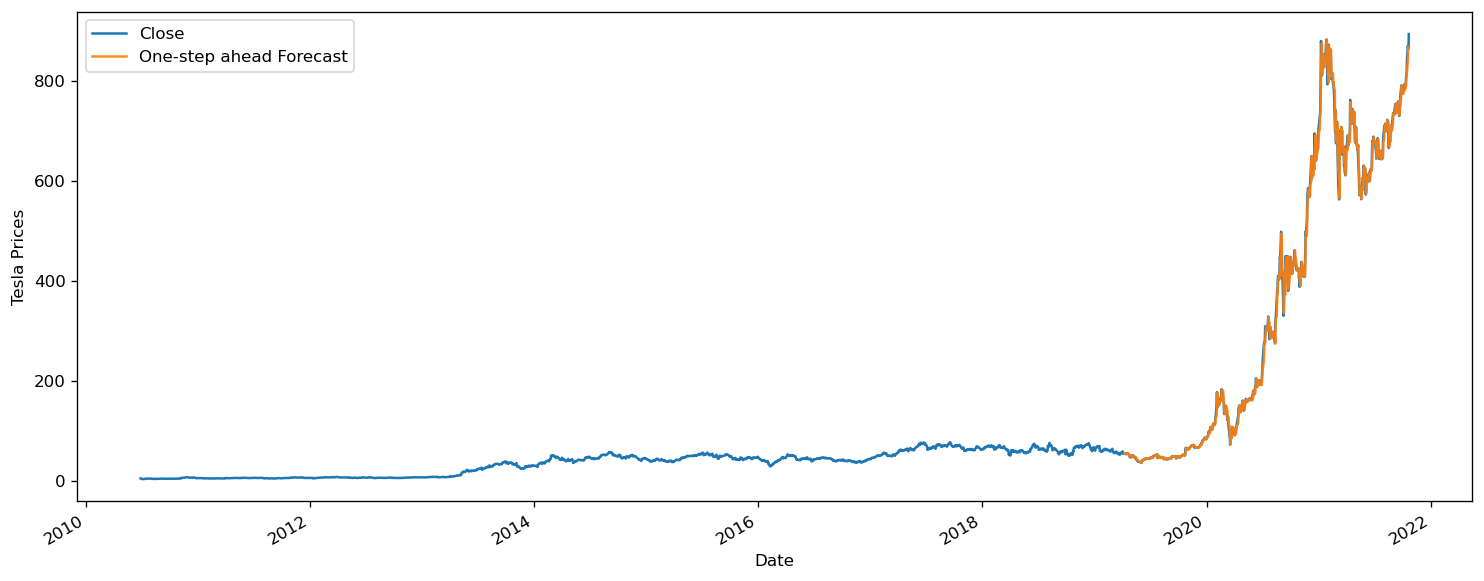

In [21]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = tsla_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Tesla Prices')
plt.legend()

plt.show();

In [22]:
value_forecasted = pred
value_truth = tsla_close['Close']['2019-04-08':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 16.11


In [23]:
mean_absolute_percentage_error(value_truth, value_forecasted)

0.02901231800858026

# PMDARIMA 

In [24]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

In [25]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [26]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7388.012, Time=2.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7381.257, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7382.434, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7382.453, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7379.904, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7382.919, Time=2.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.905 seconds


In [27]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2280
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3688.952
Date:                Thu, 28 Oct 2021   AIC                           7379.904
Time:                        07:52:15   BIC                           7385.635
Sample:                             0   HQIC                          7381.994
                               - 2280                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.4910      0.019     80.582      0.000       1.455       1.527
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):              8387.01
Prob(Q):                              0.36   Pr

In [28]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 293.2963350119687
SMAPE: 3.0105015327159252


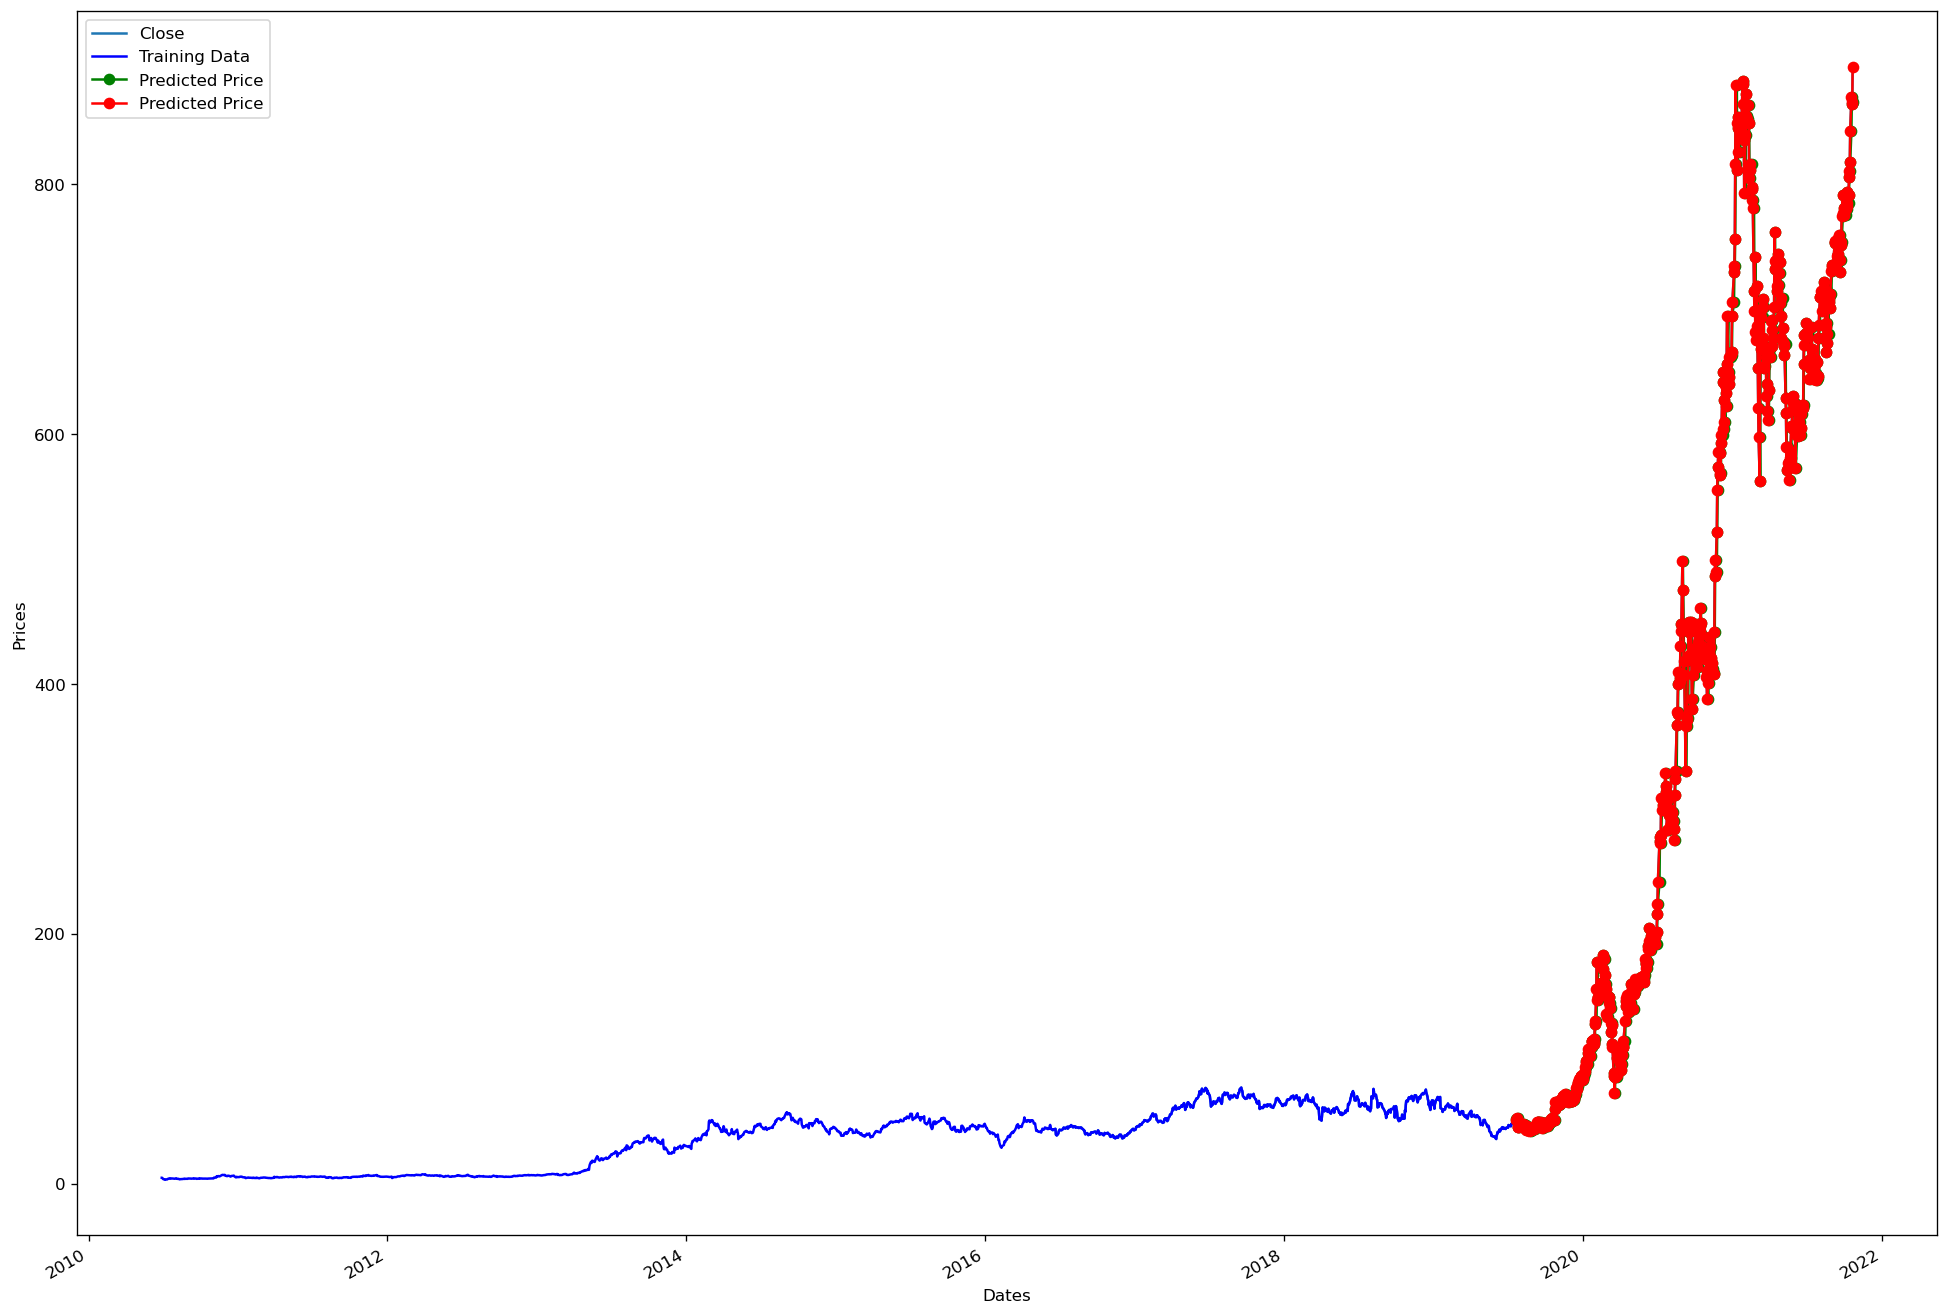

In [29]:
ax = tsla_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [30]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(293.2963350119687), 2)))

The Root Mean Squared Error of prediction is 17.13


## SARIMAX PMDARIMA

In [31]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=20.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=12762.592, Time=0.26 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8254.533, Time=5.02 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=10753.228, Time=4.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=12768.453, Time=0.22 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=8868.399, Time=1.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8069.922, Time=18.87 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=52.51 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=15.18 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=12733.866, Time=9.05 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=8071.863, Time=22.49 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=8071.867, Time=22.73 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=10759.712, Time=15.28 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=8072.564, Time=38.82 sec
 ARIMA(1,0,0)(2,1,0)[

In [32]:
model = smodel  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 367.5420319311121
SMAPE: 3.570029956154064


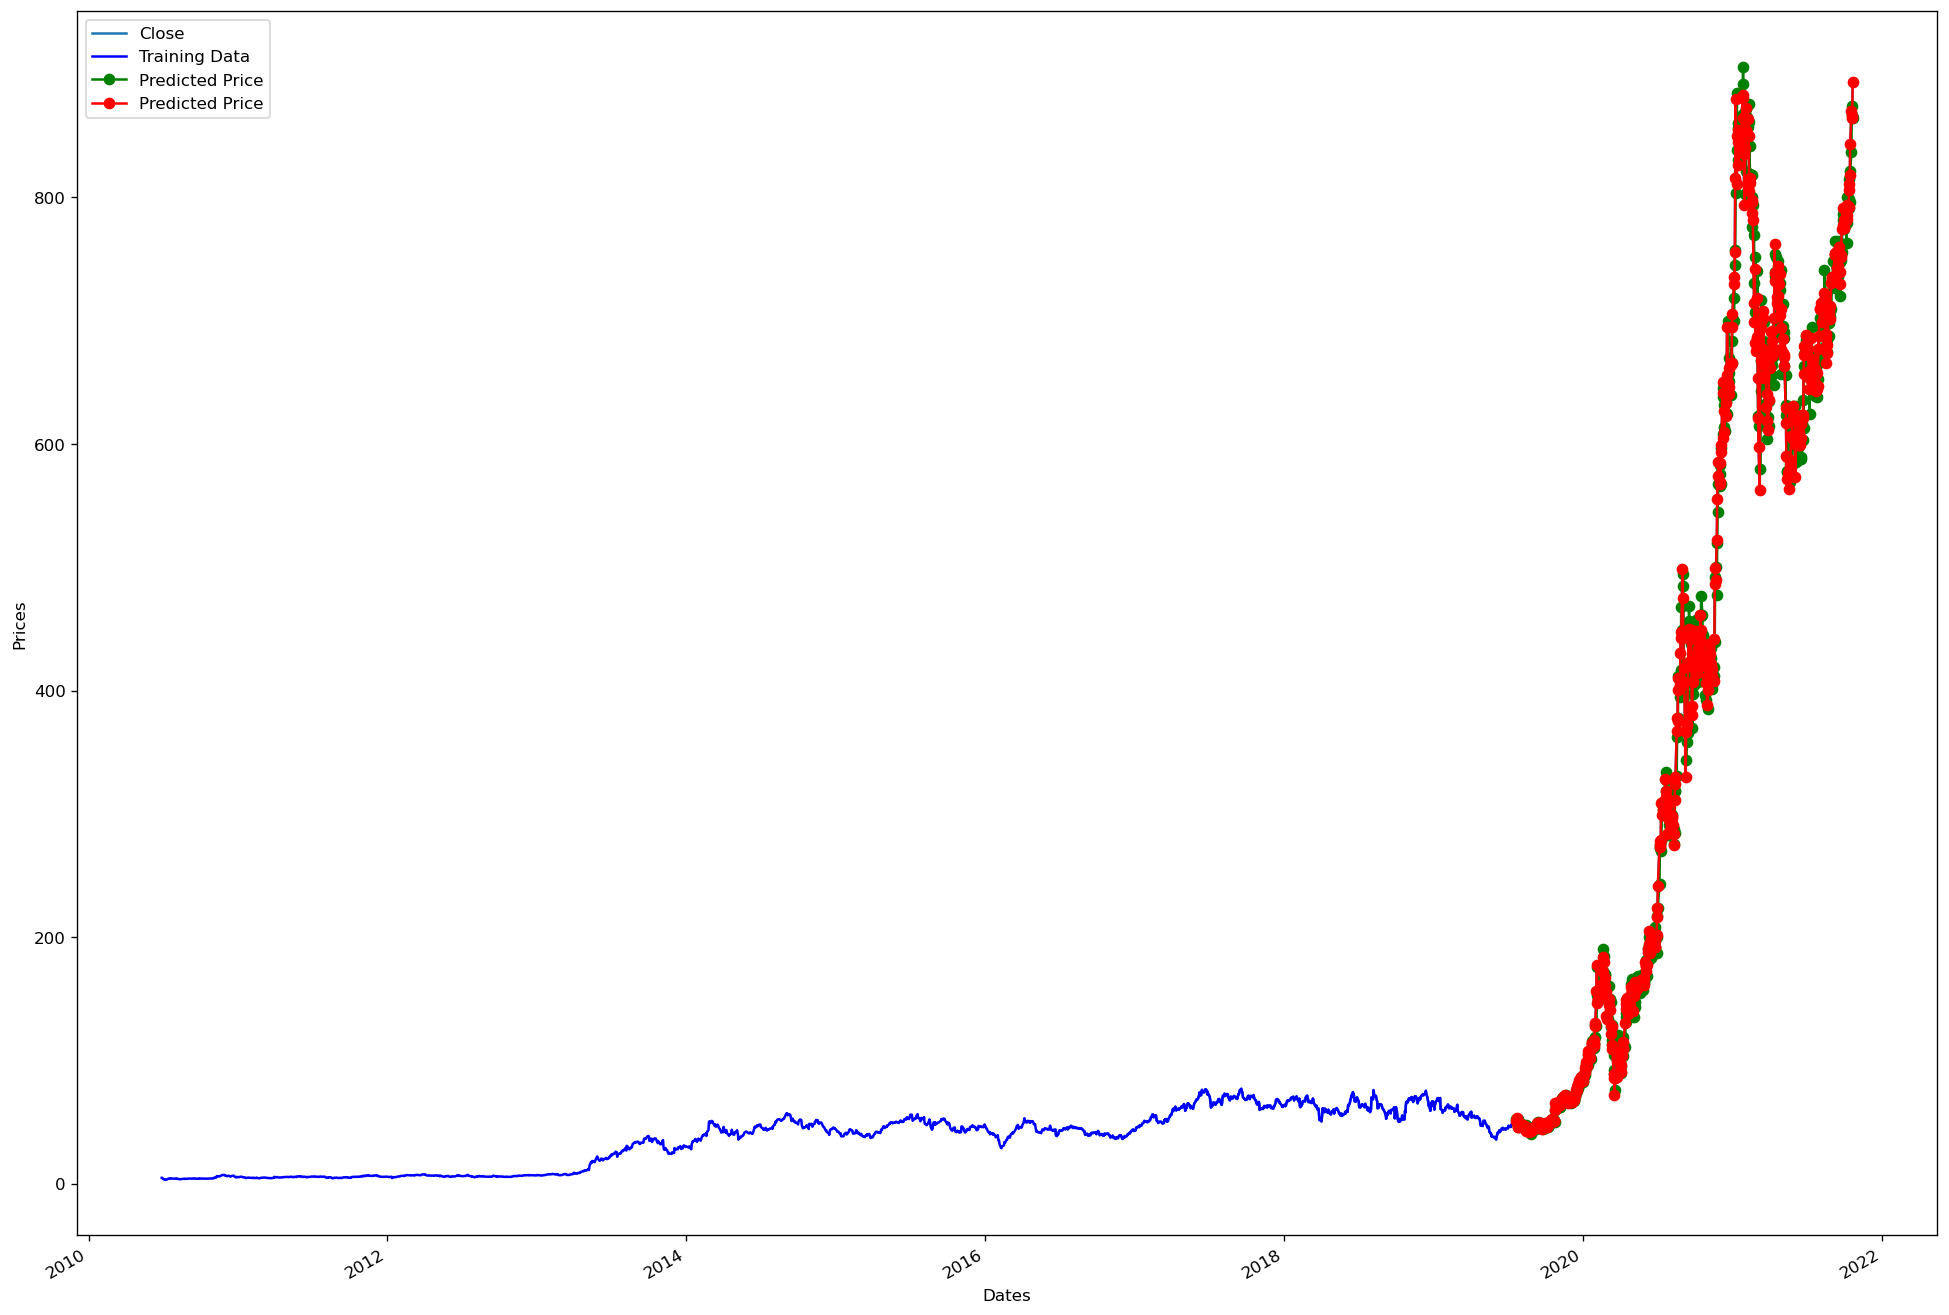

In [33]:
ax = tsla_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [35]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(367.5420319311121), 2)))

The Root Mean Squared Error of prediction is 19.17


## FBPROPHET

In [36]:
tsla_close =tsla[['Close']]

In [37]:
tsla = tsla_close.reset_index()

In [38]:
tsla

,Date,Close
0,2010-06-29,4.778000
1,2010-06-30,4.766000
2,2010-07-01,4.392000
3,2010-07-02,3.840000
4,2010-07-06,3.222000
...,...,...
2845,2021-10-15,843.030029
2846,2021-10-18,870.109985
2847,2021-10-19,864.270020
2848,2021-10-20,865.799988


In [39]:
tsla.rename(columns={'Close': 'y', 'Date': 'ds'},inplace=True)
tsla['ds'] = pd.to_datetime(tsla['ds'])
tsla['y']=tsla['y'].astype(float)

In [40]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)
df_prophet.fit(tsla)

In [41]:

fcast_time=365   # 1 year
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D')
df_forecast.tail(10)

,ds
3205,2022-10-12
3206,2022-10-13
3207,2022-10-14
3208,2022-10-15
3209,2022-10-16
3210,2022-10-17
3211,2022-10-18
3212,2022-10-19
3213,2022-10-20
3214,2022-10-21


In [42]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [43]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3210,2022-10-17,1211.575930,1133.315432,1286.939094
3211,2022-10-18,1212.513869,1139.091845,1284.055418
3212,2022-10-19,1213.558284,1136.539655,1286.575255
3213,2022-10-20,1214.044481,1139.026763,1291.761478
3214,2022-10-21,1214.453593,1139.526176,1294.440077


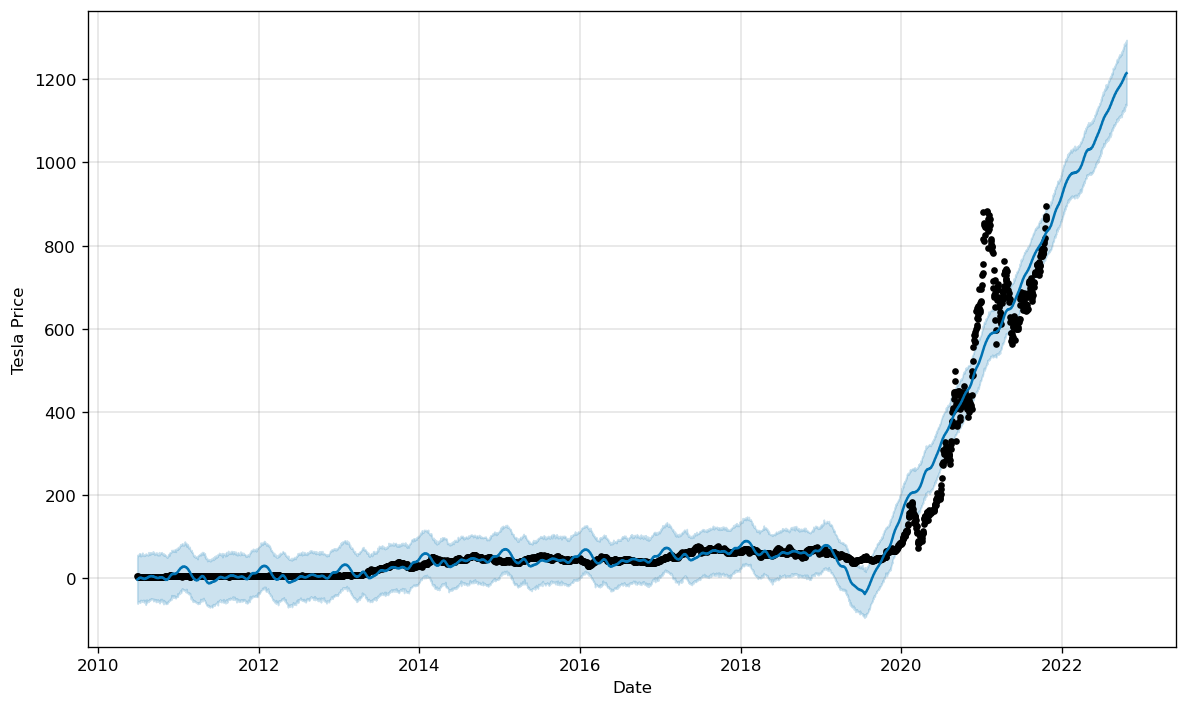

In [44]:
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Tesla Price');

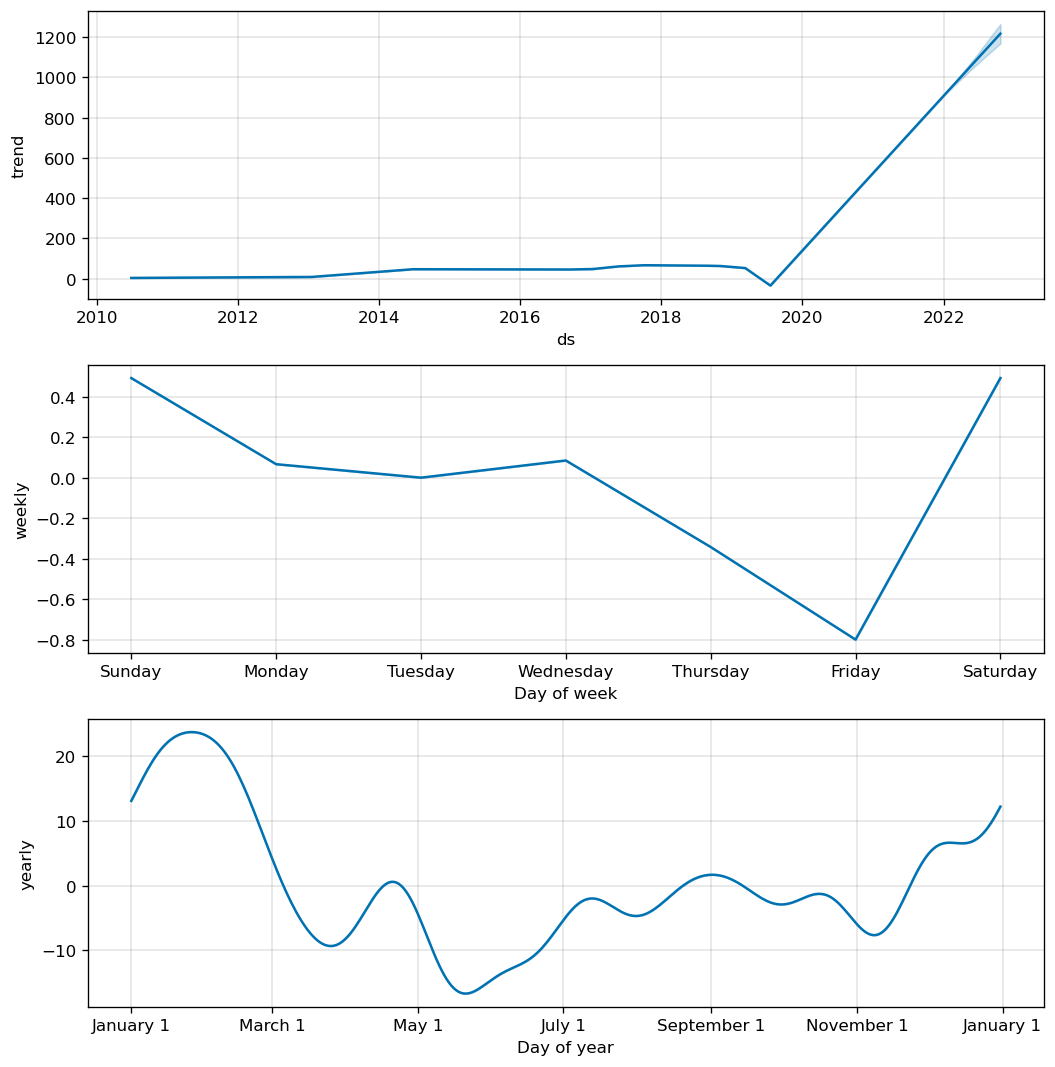

In [45]:

fig2 = df_prophet.plot_components(df_forecast)
plt.show()

In [46]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

INFO:prophet:Making 15 forecasts with cutoffs between 2013-10-23 00:00:00 and 2020-10-21 00:00:00
100%|██████████| 15/15 [03:34<00:00, 14.29s/it]


In [47]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,2650.485071,51.482862,24.206208,0.214159,0.164380,0.221623,0.175066
1,37 days 00:00:00,2897.100627,53.824721,24.860807,0.215495,0.164380,0.222944,0.179045
2,37 days 12:00:00,2872.595858,53.596603,24.923381,0.218685,0.170873,0.226018,0.173740
3,38 days 00:00:00,2855.979124,53.441362,24.743505,0.217444,0.170118,0.224826,0.177719
4,38 days 12:00:00,2815.525324,53.061524,24.573619,0.219296,0.170873,0.226083,0.175066


## Result

The ARIMA model performed the best with the lowest rmse